In [ ]:
# 실행시 등장하는 URL을 클릭하여 허용해주면 인증KEY가 나타난다. 복사하여 URL아래 빈칸에 붙여넣으면 마운트에 성공하게된다.
from google.colab import drive
drive.mount('./MyDrive')

In [ ]:
cd MyDrive/MyDrive/Capstone/code_data

# Libraries

In [11]:
import pandas as pd
import numpy as np
from glob2 import glob
import json

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import gensim
import gensim.models.word2vec as w2v
from gensim.test.utils import common_texts
from datetime import datetime
from datetime import date
from datetime import timedelta

from nltk import SnowballStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
import emoji


[nltk_data] Downloading package punkt to /Users/june/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/june/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 400)
# pd.set_option('display.max_rowwidth', 100)
pd.set_option('display.max_colwidth', 200)

# Functions

In [216]:
lmt = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
freqdist = nltk.FreqDist()
stop_words = set(stopwords.words('english'))
tweet_tokenizer = TweetTokenizer()

""" Replaces contractions from a string to their equivalents """
contraction_patterns = [ (r'won\'t', 'will not'), (r'can\'t', 'cannot'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                         (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not'), 
                         (r'i\'d', 'i would'), (r'I\'d', 'I would'), (r'he\'d', 'he would'), (r'she\'d', 'she would'), (r'they\'d', 'they would'), (r'we\'d', 'we would')]
def replaceContraction(text):
    patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
    for (pattern, repl) in patterns:
        (text, count) = re.subn(pattern, repl, text)
    return text

def capitalratio(tweet_text):
    uppers = [l for l in tweet_text if l.isupper()]
    capitalratio = len(uppers) / len(tweet_text)
    return capitalratio 

def getTokenization(sent):
    tweet_tokens = []
    sent = sent.lower()
    sent = replaceContraction(sent)

    sent = re.sub(r"http\S+", "*", sent) # http link -> '*'
    # sent = re.sub(r"@\S+", "@", sent)   # mention -> '@'
    sent = re.sub(r"@[^\s]+", "@", sent)   # mention -> '@'
    sent = re.sub(r"(#)(\S+)", r'\1 \2', sent) 

    sent = re.sub(r'([^\s\w@#\*]|_)+', '', sent) # Erasing Special Characters
    # sent = re.sub('@[^\s]+','atUser',sent)
    # sent = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',sent)
    # sent = re.sub(r'#([^\s]+)', r'\1', sent)


    # sent = re.sub('', '', sent.lower())
    # sent = [tweet_tokenizer.tokenize(sent)]
    sent = tweet_tokenizer.tokenize(sent)
    sent = [stemmer.stem(token) for token in sent]
    sent = [lmt.lemmatize(token) for token in sent]

    temp = [token for token in sent if not token in stop_words]
    url=0
    for token in temp:
        if token.startswith('*'):
            url+=1
    # tweet_tokens.append([temp])
    # tweet_tokens.append(tweet_tokenizer.tokenize(sent))
    # df_tokens = pd.DataFrame(tweet_tokens, columns=['token'])
    return temp, url

def extract_urls(entities_dicts):
    if len(entities_dicts) < 1:
        return 0
    if len(entities_dicts) == 1:
        return 1
    if len(entities_dicts) == 2:
        return 2

    # urls = []
    # urls_expanded = []

    # key = 'url'
    # key2 = 'expanded_url'
    # # print(len(entities_dict))
    # for i in entities_dicts:
    #     urls.append(i[key])
    #     urls_expanded.append(i[key2])
    # return 1, urls, urls_expanded

def getposcount(tokens):
    postag = []
    poscount = {}
    poscount['Noun']=0
    poscount['Verb']=0
    poscount['Adjective'] = 0
    poscount['Pronoun']=0
    poscount['FirstPersonPronoun']=0
    poscount['SecondPersonPronoun']=0
    poscount['ThirdPersonPronoun']=0
    poscount['Adverb']=0
    poscount['Numeral']=0
    poscount['Conjunction_inj']=0
    poscount['Particle']=0
    poscount['Determiner']=0
    poscount['Modal']=0
    poscount['Whs']=0

    Nouns = {'NN','NNS','NNP','NNPS'}
    Adverbs = {'RB','RBR','RBS'}
    Whs = {'WDT','WP','WRB'} # Composition of wh-determiner(that,what), wh-pronoun(who), wh-adverb(how)
    Verbs={'VB','VBP','VBZ','VBN','VBG','VBD','To'}
    first_person_pronouns=['i','I','me','my','mine','we','us','our','ours'] #'i',
    second_person_pronouns=['you','your','yours', 'ya']
    third_person_pronouns=['he','she','it','him','her','it','his','hers','its','they','them','their','theirs']

    for word in tokens:
        w_lower=word.lower()
        if w_lower in first_person_pronouns:
            poscount['FirstPersonPronoun']+=1
        elif w_lower in second_person_pronouns:
            poscount['SecondPersonPronoun']+=1
        elif w_lower in third_person_pronouns:
            poscount['ThirdPersonPronoun']+=1
    
    postag = nltk.pos_tag(tokens)
    for g1 in postag:
        if g1[1] in Nouns:
            poscount['Noun'] += 1
        elif g1[1] in Verbs:
            poscount['Verb']+= 1
        elif g1[1]=='ADJ'or g1[1]=='JJ':
            poscount['Adjective']+=1
        elif g1[1]=='PRP' or g1[1]=='PRON' or g1[1]=='PRP$':
            poscount['Pronoun']+=1
        elif g1[1] in Adverbs or g1[1]=='ADV':
            poscount['Adverb']+=1
        elif g1[1]=='CD':
            poscount['Numeral']+=1
        elif g1[1]=='CC' or g1[1]=='IN':
            poscount['Conjunction_inj']+=1
        elif g1[1]=='RP':
            poscount['Particle']+=1
        elif g1[1]=='MD':
            poscount['Modal']+=1
        elif g1[1]=='DT':
            poscount['Determiner']+=1
        elif g1[1] in Whs:
            poscount['Whs']+=1
    return poscount

def fetchRawText(path, events, tweetType):
    jsons = []
    for i, event in enumerate(events):
        jsons.append(glob('%s/%s/**/%s/*.json' % (path, event,tweetType)))
    for i,d in enumerate(jsons): print("%s's length is %d" %(events[i], len(d)))

    targets = []
    features = []
    for index, dataset in enumerate(jsons):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            count += 1
            if jsonFile.find("non-rumours") == -1:
                targetEvent.append(1)
            else:
                targetEvent.append(0)

            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                    try:
                        json_data = json.loads(l)
                    except:
                        print (l,"\n\n")
                        break
                    dataEvent.append(json_data)
        print(index, events[index], len(targetEvent), len(dataEvent))
        targets.append(targetEvent)
        features.append(dataEvent)

    # print("\nNumber of Events:", len(targets))
    # print("Number of tweets in the first event:", len(targets[0]))

    # targets은 targetEvent들을 리스트에 담은 것
    target_list = []
    for event in targets:
        for elem in event:
            target_list.append(elem)
    target = pd.DataFrame(target_list, columns=["target"])

    extracted_features = []

    extracted = []

    for obj_list in features:
        extracted_event = []
        for obj in obj_list:
            output_f = dict()
            output_f['text'] = obj['text']
            urls_dicts = obj['entities']['urls']
            output_f['URLcount'] = extract_urls(urls_dicts)
        
            # print(type(obj['user']))
            # print(obj['user'].contains_key('entities'))
            # if ('url' in obj['user']):
            #     output_f['hasUserURL'] = 1
            #     output_f['user_url'] = 1 if (obj['user']['url'] != None) else 0
            # elif ('entities' in obj['user']):
            #     output_f['user_entity'] = obj['user']['entities']['url']['urls']
            #     # print(obj['user']['entities']['url']['urls'])
            #     output_f['user_url'] = obj['user']['entities']['expanded_url']
            #     output_f['hasUserURL'] , _ , output_f['user_url'] = extract_urls(obj['user']['entities']['url']['urls'])
            # else:
            #     # output_f['user_entity'] = None
            #     output_f['user_url'] = 0
            #     output_f['hasUserURL'] = 0
            

            output_f['text_token'], output_f['URLcount'] = getTokenization(obj['text'])
            '''POS Tagging and text cleansing for POS'''
            temp = output_f['text']
            temp=  emoji.demojize(temp)
            temp = re.sub(r"(#)(\S+)", r'\1 \2', temp)
            temp = re.sub(r"http\S+", "", temp)
            temp = replaceContraction(temp.lower())
            temp = temp.split()
            pos_dict=getposcount(temp)
            output_f.update(pos_dict)
            output_f['emoji_count'] = emoji.emoji_count(obj['text'])

            output_f['char_count'] = len(output_f['text'])
            output_f['word_count'] = len(output_f['text'].split())

            output_f['has_question'] = "?" in output_f["text"]
            output_f['has_exclaim'] = "!" in output_f["text"]
            output_f['has_period'] = "." in output_f["text"]

            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['retweet_count'] = obj['retweet_count']
            output_f['tweet_count'] = np.log10(obj['user']['statuses_count'])
            output_f['listed_count'] = np.log10(obj['user']['listed_count'])
            output_f['friends_count'] = np.log10(obj['user']['friends_count'])
            output_f['follow_ratio'] = np.log10(obj['user']['followers_count'])

            acc_created = datetime.strptime(obj['user']['created_at'], '%a %b %d %H:%M:%S %z %Y')
            tweet_created = datetime.strptime(obj['created_at'], '%a %b %d %H:%M:%S %z %Y')
            age = (tweet_created - acc_created)
            output_f['account_age_days'] = age.days
            
            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['verified'] = obj['user']['verified']

            extracted_event.append(output_f)
        extracted_features.append(extracted_event)

    extracted_df = []
    for i, data in enumerate(extracted_features):
        temp = pd.DataFrame(data)
        temp["Event"] = events[i]
        extracted_df.append(pd.DataFrame(temp))

    final = pd.concat(extracted_df, ignore_index=True)
    final = pd.concat([final, target], axis=1)
    return final
    

# PHEME

In [217]:
path = "../pheme-rnr-dataset"
events = ['charliehebdo', 'ferguson',
          'germanwings-crash', 'ottawashooting', 'sydneysiege']
tweetType = 'source-tweet'
jsons = []
final = fetchRawText(path, events, tweetType)
target = final.target
final.verified = final.verified.replace({True: 1, False: 0}) 
final.has_question = final.has_question.replace({True: 1, False: 0}) 
final.has_exclaim = final.has_exclaim.replace({True: 1, False: 0}) 
final.has_period = final.has_period.replace({True: 1, False: 0}) 
final = final.replace(-np.inf, 0)


KeyboardInterrupt: 

In [16]:
final.drop(['text_token','text','Event','target'], axis=1, inplace=True)
final.head()

,URLcount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,HashTag,char_count,word_count,has_question,has_exclaim,has_period,capital_ratio,tweet_count,listed_count,friends_count,follow_ratio,verified
0,1,7,2,0,0,0,0,0,0,0,2,0,0,0,0,0,88,12,0,0,1,0.159091,4.803286,3.855943,2.788168,5.287349,1
1,0,3,2,0,0,0,0,0,0,0,1,0,0,0,0,1,53,6,0,0,1,0.037736,3.031812,2.146128,2.574031,3.672929,0
2,0,4,4,7,0,0,0,0,1,0,2,0,0,0,0,2,136,18,0,0,1,0.073529,3.856245,2.879669,2.772322,4.309651,0
3,2,4,5,1,0,0,0,0,0,0,0,0,2,0,1,1,138,16,0,0,1,0.101449,4.735814,5.009820,3.016197,7.187664,1
4,2,7,2,0,0,0,0,0,0,0,2,0,0,0,0,1,117,13,0,0,1,0.145299,5.021181,4.132996,2.662758,5.925434,1


In [21]:
final.to_csv('./data/_PHEME_sparse.csv', index = False)

# PHEME (Extension)

In [18]:
path = "../PHEME/all-rnr-annotated-threads"
events = ['ebola-essien', 'prince-toronto', 'putinmissing']
tweetType = 'source-tweets'
jsons = []
final_ext = fetchRawText(path,events,tweetType)
ext_target = final_ext.target
final_ext.verified = final_ext.verified.replace({True: 1, False: 0}) 
final_ext.has_question = final_ext.has_question.replace({True: 1, False: 0}) 
final_ext.has_exclaim = final_ext.has_exclaim.replace({True: 1, False: 0}) 
final_ext.has_period = final_ext.has_period.replace({True: 1, False: 0}) 
final_ext = final_ext.replace(-np.inf, 0)

ebola-essien's length is 14
prince-toronto's length is 233
putinmissing's length is 238
0 ebola-essien 14 14
1 prince-toronto 233 233
2 putinmissing 238 238


<ipython-input-4-03eea0864855>:227: RuntimeWarning: divide by zero encountered in log10
  output_f['listed_count'] = np.log10(obj['user']['listed_count'])
<ipython-input-4-03eea0864855>:228: RuntimeWarning: divide by zero encountered in log10
  output_f['friends_count'] = np.log10(obj['user']['friends_count'])


In [19]:
final_ext.drop(['text_token','text','Event','target'], axis=1, inplace=True)
final_ext.head()

,URLcount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,HashTag,char_count,word_count,has_question,has_exclaim,has_period,capital_ratio,tweet_count,listed_count,friends_count,follow_ratio,verified
0,1,2,2,1,0,0,0,0,0,0,1,0,1,0,0,0,69,8,0,0,1,0.101449,4.609338,2.170262,2.814248,4.339113,0
1,0,9,6,3,0,2,0,0,3,0,4,0,1,1,0,0,148,25,0,0,1,0.027027,2.706718,3.210319,2.245513,5.688861,1
2,0,7,4,1,1,0,0,1,0,0,2,0,3,0,1,0,119,20,0,0,1,0.025210,4.920290,3.335458,2.158362,5.366137,0
3,2,5,3,2,0,0,0,0,0,0,1,0,2,0,0,0,130,16,0,0,1,0.107692,4.188872,2.783904,2.854913,4.866571,1
4,1,4,4,2,0,0,0,0,1,0,2,0,1,0,0,0,120,15,0,0,1,0.066667,4.920290,3.335458,2.158362,5.366137,0


In [20]:
final_ext.to_csv('./data/_PHEMEext_sparse.csv', index = False)

# PHEME ALL (Reactions)

## Functions

In [218]:
import pandas as pd
import numpy as np

from glob2 import glob
import json

pd.options.display.float_format = '{:.5f}'.format

def fetchRawText_all(path, events, tweetType):
    jsons = []
    for i, event in enumerate(events):
        jsons.append(glob('%s/%s/**/%s/[0-9]*.json' % (path, event, tweetType)))
    for i,d in enumerate(jsons): print("%s's length is %d" %(events[i], len(d)))

    targets = []
    features = []
    isSrcTweet = []
    for index, dataset in enumerate(jsons):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            count += 1
            if jsonFile.find("non-rumours") == -1:
                targetEvent.append(1)
            else:
                targetEvent.append(0)
            if jsonFile.find("source-tweet") == -1:
                isSrcTweet.append(0)
            else: #if jsonFile.find("reactions") == 1:
                isSrcTweet.append(1)
                

            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                    json_data = json.loads(l)
                    dataEvent.append(json_data)
        targets.append(targetEvent)
        features.append(dataEvent)
        # isSrcTweet.append(isSrcTweet)

    # print("\nNumber of Events:", len(targets))
    # print("Number of tweets in the first event:", len(targets[0]))

    # targets은 targetEvent들을 리스트에 담은 것
    target_list = []
    for event in targets:
        for elem in event:
            target_list.append(elem)
    target = pd.DataFrame(target_list, columns=["target"])
    isSrcTweet = pd.DataFrame(isSrcTweet, columns=["isSrcTweet"])

    extracted_features = []

    extracted = []

    for obj_list in features:
        extracted_event = []
        for obj in obj_list:
            output_f = dict()

            if ('text' in obj):
                output_f['text'] = obj['text']
            else:
                output_f['text'] = None
            if ('id' in obj):
                output_f['id'] = obj['id']
            else:
                output_f['id'] = None
            if ('in_reply_to_status_id' in obj):
                output_f['pid'] = obj['in_reply_to_status_id']
            else:
                output_f['pid'] = None
            output_f['emoji_count'] = emoji.emoji_count(obj['text'])
            urls_dicts = obj['entities']['urls']
            if "media" in obj['entities']:
                output_f['has_media'] = len(obj['entities']['media'])
                # output_f['media_type'] = obj['entities']['media'][0]['type']
            else:
                output_f['has_media'] = 0
                # output_f['media_type'] = 0
            output_f['URLcount'] = len(urls_dicts)
            # output_f['URLcount'] = extract_urls(urls_dicts)
            # temp = obj['text'].lower()
            temp = re.sub(r"http\S+", "HTTPURL", obj['text'])
            verification = 0
            verification += len(re.findall(r'is(that|this|it) true', obj['text']))
            verification += len(re.findall(r'wh[a]*t[?!|!?][?!|!?]*', obj['text']))
            verification += len(re.findall(r'(rumour|rumor|debunk)', obj['text']))
            verification += len(re.findall(r'(real?|really?|uncomfirmed)', obj['text']))
            verification += len(re.findall(r'(that|this|it) is not true', obj['text']))
            verification += len(re.findall(r'(that|this|it) is false', obj['text']))
            verification += len(re.findall(r'(h[m]*)', obj['text']))
            output_f['Skepticism'] = verification            
            url, mention = 0, 0
            for token in temp:
                if token.startswith('HTTPURL'):
                # if token.startswith (r"http\S+"):
                    url+=1
                if token.startswith('@'):
                    mention+=1 
            # output_f['URLcount'] = url
            output_f['MentionCount'] = mention

            '''POS Tagging'''
            temp = output_f['text']
            temp = replaceContraction(temp.lower())
            temp = re.sub(r"(#)(\S+)", '', temp)
            temp = re.sub(r"(@)(\S+)", '', temp)
            temp = re.sub(r"http\S+", "", temp)
            temp = re.sub(r'([^\s\w#\*]|_)+', '', temp) # Erasing Special Characters

            temp = temp.split()
            pos_dict=getposcount(temp)
            output_f['token_for_POS'] = temp
            output_f.update(pos_dict)

            output_f['char_count'] = len(output_f['text'])
            output_f['word_count'] = len(output_f['text'].split())

            # output_f['HashTag'] = len(obj['entities'][0]['hashtags'])
            output_f['HashTag'] = len(obj['entities']['hashtags'])
            
            output_f['has_question'] = "?" in output_f["text"]
            output_f['has_exclaim'] = "!" in output_f["text"]
            output_f['has_period'] = "." in output_f["text"]

            output_f['retweet_count'] = obj['retweet_count']
            output_f['isRT'] = obj['retweeted']

            output_f['tweet_count'] = np.log10(obj['user']['statuses_count'])
            output_f['listed_count'] = np.log10(obj['user']['listed_count'])
            output_f['friends_count'] = np.log10(obj['user']['friends_count'])
            output_f['follow_ratio'] = np.log10(obj['user']['followers_count'])
            
            acc_created = datetime.strptime(obj['user']['created_at'], '%a %b %d %H:%M:%S %z %Y')
            tweet_created = datetime.strptime(obj['created_at'], '%a %b %d %H:%M:%S %z %Y')
            age = (tweet_created - acc_created)
            output_f['account_age_days'] = age.days
            output_f['tweet_created'] = datetime.timestamp(tweet_created)
            # output_f['tweet_created2'] = tweet_created



            output_f['capital_ratio']=(capitalratio(obj['text']))
            output_f['verified'] = obj['user']['verified']

            extracted_event.append(output_f)
        extracted_features.append(extracted_event)

    extracted_df = []
    # print(events)
    # print(len(extracted_features))
    for i, data in enumerate(extracted_features):
        temp = pd.DataFrame(data)
        temp["Event"] = events[i]
        extracted_df.append(pd.DataFrame(temp))

    final = pd.concat(extracted_df, ignore_index=True)
    final = pd.concat([final, isSrcTweet ,target], axis=1)
    final.pid = final.pid
    return final

def depth(x):
    if type(x) is dict and x:
        return 1 + max(depth(x[a]) for a in x)
    if type(x) is list and x:
        return 1 + max(depth(a) for a in x)
    return 0

def getThreadData(path, events):
    import re

    sources = []
    for i, event in enumerate(events):
        sources.append(glob('%s/%s/*/*' % (path, event)))
    roots = []
    children = []
    features = []
    isSrcTweet = []
    for num, event in enumerate(sources):
        for index, dataset in enumerate(event):
            # print(dataset)
            # children.append(glob('%s/reactions/*/*' % (dataset)))
            childs = [os.path.basename(x) for x in glob('%s/reactions/*.json' % (dataset))]
            reext = re.compile(r'(.*?)\.json')
            childs = (reext.match(child) for child in childs)
            children.append([match.group(1) for match in childs if match])
            # print(dataset)
            roots.append(os.path.basename(dataset))

    df = pd.DataFrame(roots, columns=['Root'])
    df = pd.concat([df,pd.DataFrame(children)],axis=1)
    
    structfile = []
    for i, event in enumerate(events):
        structfile.append(glob('%s/%s/**/[0-9]*/structure.json' % (path, event)))

    for i,d in enumerate(structfile): print("%s's structure.json number is %d" %(events[i], len(d)))
    # print(structfile)

    thread_depths = []
    thread_roots = []
    for index, dataset in enumerate(structfile):
        targetEvent = []
        dataEvent = []
        count = 0  # help var
        for jsonFile in dataset:
            # print(jsonFile)
            match = re.search("/([0-9]*)/", jsonFile)
            # p.match("lalalaI want this partlalala").group(1)
            rootname = match.group(1) if match else None
            # print(rootname)
            with open(jsonFile, 'r') as f:
                for l in f.readlines():
                    if not l.strip():  # skip empty lines
                        continue
                json_data = json.loads(l)
                # print(json_data)
                thread_depth = depth(json_data)
                thread_depths.append([rootname,thread_depth])
                # thread_roots.append(rootname)
    df_depth = pd.DataFrame(thread_depths, columns=['Root', 'depth'])
    df = pd.merge(df, df_depth, on="Root")
                
    
    # return pd.DataFrame(thread_depths)
    return df

In [230]:
import warnings
warnings.filterwarnings("ignore")

def getThreadInfo(structure, df):
    threadInfo = []
    thread_depth = structure[['Root', 'depth']]
    structure = structure.drop('depth', axis=1)
    for index, data in enumerate(structure.Root):
        tweetInfo = []
        # print("data: %s\n" %(data))
        # print("data: %s\n%s\n" %(data, structure.loc[index,0:].values))
        # print("root: %s\tFirst reaction: %s\n" %(data, structure.loc[index,0]))

        
        pid = int(data)
        thread = structure.loc[structure['Root']==pid].dropna(axis=1)
        # threadRange = structure.loc[structure['Root']==data].any().sum()-1
        # print(structure)
        threadRange = len(structure.iloc[index,:].dropna())

        # 아래로는 성공적인 Features
        friends_count = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        friends_countavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['friends_count'].values) for childid in structure.loc[index,:].dropna()])
        words_count = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['word_count'].values) for childid in structure.loc[index,:].dropna()])
        char_count = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['char_count'].values) for childid in structure.loc[index,:].dropna()])
        hashtagavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['HashTag'].values) for childid in structure.loc[index,:].dropna()])
        hashtagpercentage = np.sum([np.any(df.loc[(df['id'] == int(childid))]['HashTag']) for childid in structure.loc[index,:].dropna()])/threadRange
        urlavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        urlratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['URLcount'].values) for childid in structure.loc[index,:].dropna()])
        mentionsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])
        mentionpercentage = np.sum([np.any(df.loc[(df['id'] == int(childid))]['MentionCount'].values) for childid in structure.loc[index,:].dropna()])/threadRange
        verifiedratio = np.mean([np.any(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])
        verifiedsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['verified'].values) for childid in structure.loc[index,:].dropna()])
        retweetsum = np.sum([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        retweetavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        retweetstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['retweet_count'].values) for childid in structure.loc[index,:].dropna()])
        accageavg = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['account_age_days'].values) for childid in structure.loc[index,:].dropna()])
        accagestd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['account_age_days'].values) for childid in structure.loc[index,:].dropna()])
        emojistd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])
        emojimean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['emoji_count'].values) for childid in structure.loc[index,:].dropna()])
        mediaratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_media'].values) for childid in structure.loc[index,:].dropna()])
        questionratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_question'].values) for childid in structure.loc[index,:].dropna()])
        exclamationratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_exclaim'].values) for childid in structure.loc[index,:].dropna()])
        periodratio = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['has_period'].values) for childid in structure.loc[index,:].dropna()])
        FPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['FirstPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        FPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['FirstPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        SPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['SecondPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        SPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['SecondPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        TPPmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['ThirdPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        TPPstd = np.std([np.sum(df.loc[(df['id'] == int(childid))]['ThirdPersonPronoun'].values) for childid in structure.loc[index,:].dropna()])
        Skepticismmean = np.mean([np.sum(df.loc[(df['id'] == int(childid))]['Skepticism'].values) for childid in structure.loc[index,:].dropna()])

        # Get the lifetime of thread
        # root_created = df.loc[(df['id'] == int(pid))].tweet_created.sum()
        # try:
        #     thread_latest = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created'].values) for childid in structure.loc[index,'0':].dropna()])
        # except:
        # #     print([df.loc[(df['id'] == int(childid))]['tweet_created'].values for childid in structure.loc[index,'0':].dropna()])
        #     print("error")

        # thread_life = thread_latest - root_created
        try:
            thread_life = np.max([np.sum(df.loc[(df['id'] == childid)]['tweet_created']) for childid in structure.loc[index,:].dropna()] - df.loc[(df['id'] == pid)].tweet_created.sum())
        except:
            print("index:", index)

        # 해당 스레드의 트윗 개수
        thread_node_count = len([childid for childid in structure.loc[index,:].dropna()]) 
        # print("thread_node_count:",thread_node_count,", threadRange:",threadRange, "lastest Thread:", thread_latest )
        # print(structure.loc[structure.Root == data])

        tweetInfo.append(data)
        tweetInfo.append(friends_count)
        tweetInfo.append(friends_countavg)
        tweetInfo.append(words_count)
        tweetInfo.append(char_count)
        tweetInfo.append(hashtagavg)
        tweetInfo.append(hashtagsum)
        tweetInfo.append(hashtagpercentage)
        tweetInfo.append(urlavg)
        tweetInfo.append(urlstd)
        tweetInfo.append(urlratio)
        tweetInfo.append(mentionsum)
        tweetInfo.append(mentionavg)
        tweetInfo.append(mentionpercentage)
        tweetInfo.append(thread_node_count)
        tweetInfo.append(verifiedratio)
        tweetInfo.append(verifiedsum)
        tweetInfo.append(retweetsum)
        tweetInfo.append(retweetavg)
        tweetInfo.append(retweetstd)
        tweetInfo.append(accageavg)
        tweetInfo.append(accagestd)
        tweetInfo.append(thread_life)
        tweetInfo.append(emojistd)
        tweetInfo.append(emojimean)
        tweetInfo.append(mediaratio)
        tweetInfo.append(questionratio)
        tweetInfo.append(exclamationratio)
        tweetInfo.append(periodratio)
        tweetInfo.append(FPPmean)
        tweetInfo.append(FPPstd)
        tweetInfo.append(SPPmean)
        tweetInfo.append(SPPstd)
        tweetInfo.append(TPPmean)
        tweetInfo.append(TPPstd)
        tweetInfo.append(Skepticismmean)

        threadInfo.append(tweetInfo)

        result = pd.DataFrame(threadInfo, columns=['Root', 'SUM FriendsCount','AVG FriendsCount', 'AVG WordCount', 'AVG CharCount', 'AVG HashTag', 'SUM HashTag', 'Ratio HashTag', 'AVG Url','STD Url','RATIO Url','SUM Mention', 'AVG Mention', 'Ratio Mention', 'Tweets Count', 'Ratio Verified','SUM Verified','SUM RT', 'AVG RT','STD RT', 'AVG AccAge', 'STD AccAge', 'thread_time', "STD Emoji","AVG Emoji","Ratio Media",'RATIO Question', 'RATIO Exclaim','RATIO Period', 'AVG FPP','STD FPP','AVG SPP','STD SPP','AVG TPP','STD TPP','AVG Skepticism'])
        result = pd.merge(thread_depth, result, on="Root").drop(['Root'], axis=1)
    # print(threadInfo)
    return result

In [220]:
len(structure_ext.loc[0,'0':].dropna())

AttributeError: 'list' object has no attribute 'loc'

In [435]:
threadRange = len(structure_ext.loc[9,'0':].dropna())
print(threadRange)
print(np.sum([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['HashTag'].values) for childid in structure_ext.loc[9,'0':].dropna()]))
np.sum([np.any(all_ext.loc[(all_ext['id'] == int(childid))]['HashTag'].values) for childid in structure_ext.loc[9,'0':].dropna()])

15
3


3

## PHEME ALL Create

420120 Tweets

In [3]:
# print(pheme_all.shape)
# pheme_all.loc[pheme_all['Event']=='charliehebdo'].shape

In [243]:
path = "../pheme-rnr-dataset"
# events = ['charliehebdo', 'ferguson',
#           'germanwings-crash', 'ottawashooting', 'sydneysiege']
events = ['ottawashooting']
# events = [ 'sydneysiege']

tweetType = '*'
final = fetchRawText_all(path, events, tweetType)
final.verified = final.verified.replace({True: 1, False: 0}) 
final.has_question = final.has_question.replace({True: 1, False: 0}) 
final.has_exclaim = final.has_exclaim.replace({True: 1, False: 0}) 
final.has_period = final.has_period.replace({True: 1, False: 0}) 
final = final.replace(-np.inf, 0)

pheme_all = final

ottawashooting's length is 12284


KeyboardInterrupt: 

In [500]:
pheme_all.to_csv('./data/all/_PHEMEall.csv', index = False)

In [501]:
pheme_structure = getThreadData(path, events)
pheme_structure.to_csv('./data/all/_PHEME_structure.csv', index = False)


## PHEME ALL Process

In [502]:
all_pheme = pd.read_csv("./data/all/_PHEMEall.csv")
structure_pheme = pd.read_csv("./data/all/_PHEME_structure.csv")
print(all_pheme.shape)
print(structure_pheme.shape)

(125208, 34)
(5802, 346)


In [503]:
pheme_thread = getThreadInfo(structure_pheme, all_pheme)
pheme_thread = pheme_thread.fillna(0)
pheme_thread

,SUM FriendsCount,AVG FriendsCount,AVG WordCount,AVG HashTag,SUM HashTag,Percent HashTag,AVG Url,AVG Mention,Percent Mention
0,54.85092,3.04727,19.05556,0.00000,0.00000,0.00000,0.22222,1.77778,1.00000
1,21.91754,3.13108,13.57143,0.14286,1.00000,0.14286,0.14286,2.00000,1.00000
2,16.88907,2.81484,14.50000,0.33333,2.00000,0.16667,0.16667,1.66667,1.00000
3,24.22340,2.69149,15.88889,0.55556,5.00000,0.44444,0.33333,1.33333,1.00000
4,10.72064,2.68016,15.50000,0.50000,2.00000,0.25000,0.50000,1.25000,1.00000
...,...,...,...,...,...,...,...,...,...
5797,220.85182,2.56804,14.61628,0.09302,8.00000,0.09302,0.26744,2.58140,1.00000
5798,232.80737,2.19630,14.38679,0.24528,26.00000,0.11321,0.01887,1.34906,1.00000
5799,17.67264,2.52466,17.57143,1.57143,11.00000,0.57143,0.28571,1.00000,1.00000
5800,113.39473,2.41265,14.53191,0.08511,4.00000,0.08511,0.08511,1.76596,1.00000


In [504]:
pheme_thread.to_csv('./data/all/_PHEME_thread.csv', index = False)


## PHEMEext Create

In [221]:
path = "../PHEME/all-rnr-annotated-threads"
events = ['ebola-essien', 'prince-toronto', 'putinmissing']
# events = ['ebola-essien']
tweetType = '*'

all_ext = fetchRawText_all(path, events, tweetType)
all_ext.isRT = all_ext.isRT.replace({True: 1, False: 0}) 
all_ext.verified = all_ext.verified.replace({True: 1, False: 0}) 
all_ext.has_question = all_ext.has_question.replace({True: 1, False: 0}) 
all_ext.has_exclaim = all_ext.has_exclaim.replace({True: 1, False: 0}) 
all_ext.has_period = all_ext.has_period.replace({True: 1, False: 0}) 
all_ext = all_ext.replace(-np.inf, 0)

print(all_ext.shape)
all_ext.head(5)

ebola-essien's length is 226
prince-toronto's length is 902
putinmissing's length is 835
(1963, 42)


,text,id,pid,emoji_count,has_media,URLcount,Skepticism,MentionCount,token_for_POS,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,isRT,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,tweet_created,capital_ratio,verified,Event,isSrcTweet,target
0,@Mourinholic 😕😕 http://t.co/sFoV1v8uDo,521410632953131008,521369179392581632.00000,2,1,0,2,1,[],0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,3,0,0,0,1,0,0,4.89226,1.20412,3.13799,3.56062,1569,1413148956.00000,0.10526,0,ebola-essien,0,1
1,“@Mourinholic: Micheal Essien denying the Ebola rumours like https://t.co/8Yo8iLgISS”,521373142347153409,521369179392581632.00000,0,0,1,5,1,"[micheal, essien, denying, the, ebola, rumours, like]",2,2,1,0,0,0,0,0,0,1,0,1,0,0,85,9,0,0,0,1,0,0,3.58827,0.90309,3.10072,3.10653,242,1413140018.00000,0.10588,0,ebola-essien,0,1
2,@Mourinholic Hmmm.,521369380249432064,521369179392581632.00000,0,0,0,1,1,[hmmm],1,0,0,0,0,0,0,0,0,0,0,0,0,0,18,2,0,0,0,1,0,0,4.52289,1.17609,1.89209,3.14426,653,1413139121.00000,0.11111,0,ebola-essien,0,1
3,"@Mourinholic Even though it was against us, it was a bloody amazing goal.",521370496928337920,521369179392581632.00000,0,0,0,3,1,"[even, though, it, was, against, us, it, was, a, bloody, amazing, goal]",1,2,2,3,1,0,2,1,0,2,0,1,0,0,73,13,0,0,0,1,0,0,2.96755,0.00000,2.35025,1.75587,1762,1413139387.00000,0.02740,0,ebola-essien,0,1
4,@CdtChoco1er thanks bro.,521370224256614400,521370061550809088.00000,0,0,0,2,1,"[thanks, bro]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,24,3,0,0,0,1,0,0,4.62381,2.20140,2.82607,4.35601,1570,1413139322.00000,0.08333,0,ebola-essien,0,1


In [244]:
all_ext.to_csv('./data/all/_PHEMEextall.csv', index = False)

In [223]:
import os
# ext_structure = getThreadData(path, events)
structure_ext = getThreadData(path, events)

ebola-essien's structure.json number is 14
prince-toronto's structure.json number is 233
putinmissing's structure.json number is 238


In [339]:
structure_ext.to_csv('./data/all/_PHEMEext_structure.csv', index = False)

## PHEME EXT PROCESS

In [26]:
all_ext = pd.read_csv("./data/all/_PHEMEextall.csv")
structure_ext = pd.read_csv("./data/all/_PHEMEext_structure.csv")
ext_y = pd.read_csv('./data/_PHEMEext_target.csv')
print(all_ext.shape)
print(structure_ext.shape)

(1963, 38)
(485, 28)


In [242]:
ext_thread.to_csv('./data/all/_PHEMEext_thread.csv', index = False)

In [231]:
# SUM FriendsCount	AVG FriendsCount 들이 -inf 값 포함
ext_thread = getThreadInfo(structure_ext, all_ext)
# ext_thread = ext_thread.replace(-np.inf, 0)
ext_thread = ext_thread.fillna(0)
ext_thread = ext_thread.replace(-np.inf, 0)
ext_thread.head(15)
# ext_thread.to_csv('./data/_PHEMEext_thread.csv', index = False)

,depth,SUM FriendsCount,AVG FriendsCount,AVG WordCount,AVG CharCount,AVG HashTag,SUM HashTag,Ratio HashTag,AVG Url,STD Url,RATIO Url,SUM Mention,AVG Mention,Ratio Mention,Tweets Count,Ratio Verified,SUM Verified,SUM RT,AVG RT,STD RT,AVG AccAge,STD AccAge,thread_time,STD Emoji,AVG Emoji,Ratio Media,RATIO Question,RATIO Exclaim,RATIO Period,AVG FPP,STD FPP,AVG SPP,STD SPP,AVG TPP,STD TPP,AVG Skepticism
0,4,41.55384,2.77026,8.80000,67.13333,0.00000,0,0.00000,0.40000,0.48990,0.40000,16,1.06667,0.93333,15,0.00000,0,118,7.86667,29.16817,939.13333,510.37501,-1413139073.00000,0.54160,0.20000,0.06667,0.06667,0.13333,0.93333,0.13333,0.33993,0.00000,0.00000,0.40000,0.71181,3.46667
1,4,49.35564,2.59767,7.47368,50.63158,0.10526,2,0.10526,0.00000,0.00000,0.00000,23,1.21053,0.94737,19,0.05263,1,10416,548.21053,2322.56083,999.36842,478.35004,-1413138772.00000,0.30689,0.10526,0.00000,0.05263,0.31579,0.26316,0.26316,0.63595,0.36842,0.58133,0.10526,0.30689,2.68421
2,2,16.71898,2.38843,12.42857,78.42857,0.00000,0,0.00000,0.00000,0.00000,0.00000,7,1.00000,0.85714,7,0.00000,0,127,18.14286,44.03385,1126.85714,792.28863,-1413357828.00000,0.00000,0.00000,0.00000,0.14286,0.14286,0.57143,0.00000,0.00000,0.00000,0.00000,0.71429,0.45175,2.71429
3,3,31.75615,2.44278,11.15385,74.07692,0.07692,1,0.07692,0.23077,0.42133,0.23077,17,1.30769,0.92308,13,0.07692,1,195,15.00000,51.09719,700.38462,553.63047,-1413140606.00000,0.00000,0.00000,0.15385,0.07692,0.07692,0.61538,0.30769,0.46154,0.07692,0.26647,0.38462,0.62493,3.23077
4,2,10.72732,2.14546,11.60000,96.00000,0.00000,0,0.00000,0.40000,0.48990,0.40000,12,2.40000,1.00000,5,0.00000,0,197,39.40000,78.30096,1099.60000,695.26760,-1413136436.00000,0.00000,0.00000,0.00000,0.20000,0.00000,0.80000,0.20000,0.40000,0.00000,0.00000,0.00000,0.00000,4.20000
5,5,52.33015,2.61651,12.55000,84.85000,0.05000,1,0.05000,0.25000,0.43301,0.25000,26,1.30000,0.95000,20,0.10000,2,1469,73.45000,319.01481,1295.35000,584.85667,-1413142049.00000,0.35707,0.15000,0.00000,0.05000,0.20000,0.55000,0.75000,0.88741,0.15000,0.35707,0.20000,0.40000,4.10000
6,6,73.00639,2.70394,10.55556,85.66667,0.00000,0,0.00000,0.07407,0.26189,0.07407,39,1.44444,0.96296,27,0.00000,0,581,21.51852,108.54948,1154.18519,521.98929,-1413133719.00000,0.62854,0.22222,0.40741,0.22222,0.07407,0.66667,0.03704,0.18885,0.22222,0.49690,0.44444,0.95581,2.70370
7,3,23.82766,2.64752,13.00000,96.66667,0.00000,0,0.00000,0.00000,0.00000,0.00000,14,1.55556,0.88889,9,0.00000,0,849,94.33333,243.60761,835.44444,329.65845,-1413137001.00000,0.41574,0.22222,0.44444,0.00000,0.00000,0.66667,0.00000,0.00000,0.00000,0.00000,0.22222,0.41574,3.88889
8,5,23.89819,2.38982,10.70000,78.80000,0.00000,0,0.00000,0.10000,0.30000,0.10000,14,1.40000,0.90000,10,0.00000,0,153,15.30000,36.77785,855.00000,724.36745,-1413136852.00000,0.00000,0.00000,0.00000,0.10000,0.00000,0.80000,0.10000,0.30000,0.00000,0.00000,0.50000,0.92195,3.20000
9,3,39.22661,2.45166,12.62500,87.12500,0.31250,5,0.31250,0.00000,0.00000,0.00000,20,1.25000,0.93750,16,0.00000,0,144,9.00000,34.59949,1087.06250,550.85235,-1413192966.00000,0.00000,0.00000,0.00000,0.18750,0.18750,0.31250,0.06250,0.24206,0.25000,0.75000,0.50000,0.70711,3.50000


### 👇 Thread 정보만을 추출한 결과
아래의 Features들은 모두 한 Root 트윗에 달린 Thread의 정보를 포함한다.

---

In [232]:
ext_thread.describe()

,depth,SUM FriendsCount,AVG FriendsCount,AVG WordCount,AVG CharCount,AVG HashTag,SUM HashTag,Ratio HashTag,AVG Url,STD Url,RATIO Url,SUM Mention,AVG Mention,Ratio Mention,Tweets Count,Ratio Verified,SUM Verified,SUM RT,AVG RT,STD RT,AVG AccAge,STD AccAge,thread_time,STD Emoji,AVG Emoji,Ratio Media,RATIO Question,RATIO Exclaim,RATIO Period,AVG FPP,STD FPP,AVG SPP,STD SPP,AVG TPP,STD TPP,AVG Skepticism
count,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000,485.00000
mean,2.19794,10.84186,2.72841,14.26121,99.20002,0.84626,1.79381,0.41010,0.34205,0.13854,0.33213,5.11959,0.88153,0.58595,4.04742,0.10093,0.26186,54.36907,6.15717,12.34183,1407.53838,306.40342,-1420562049.76082,0.08762,0.05846,0.17974,0.21324,0.14564,0.75296,0.27241,0.24974,0.09706,0.08811,0.35316,0.25523,3.22114
std,1.70257,12.99575,0.51150,4.16138,25.41987,1.11570,2.08169,0.41270,0.42563,0.21214,0.40211,8.14323,0.80019,0.40283,4.83785,0.25315,0.56361,514.15357,27.35858,112.42284,599.53507,330.59886,5668373.99026,0.34064,0.28811,0.32602,0.32331,0.26356,0.30629,0.43975,0.39512,0.28692,0.19393,0.46498,0.35308,1.49462
min,1.00000,0.00000,0.00000,4.00000,39.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,2.00000,0.12500,0.00000,5.00000,0.00000,-1426484176.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.00000,2.98811,2.46835,11.00000,81.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,2.00000,1.75000,0.00000,1028.33333,0.00000,-1426316918.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,2.00000
50%,2.00000,5.47855,2.73241,14.00000,96.85714,0.50000,1.00000,0.25000,0.15789,0.00000,0.14286,2.00000,0.93333,0.75000,2.00000,0.00000,0.00000,5.00000,2.75000,1.00000,1390.61538,186.20201,-1415143918.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.16667,0.00000,3.00000
75%,3.00000,13.37434,3.00346,17.00000,121.00000,1.00000,3.00000,1.00000,0.53846,0.39031,0.50000,6.00000,1.25000,0.96296,5.00000,0.00000,0.00000,12.00000,5.00000,4.00000,1924.00000,575.88878,-1415124588.00000,0.00000,0.00000,0.20000,0.33333,0.20000,1.00000,0.50000,0.47140,0.00000,0.00000,0.60000,0.48412,4.00000
max,16.00000,78.86282,4.38684,29.00000,143.00000,7.00000,15.00000,1.00000,2.00000,0.94281,1.00000,44.00000,6.50000,1.00000,27.00000,1.00000,5.00000,10416.00000,548.21053,2322.56083,3021.00000,1371.00000,-1413125063.00000,4.00000,4.00000,1.00000,1.00000,1.00000,1.00000,4.00000,2.00000,3.00000,1.00000,2.00000,1.93907,9.00000


In [234]:
ext_thread.columns

Index(['depth', 'SUM FriendsCount', 'AVG FriendsCount', 'AVG WordCount',
       'AVG CharCount', 'AVG HashTag', 'SUM HashTag', 'Ratio HashTag',
       'AVG Url', 'STD Url', 'RATIO Url', 'SUM Mention', 'AVG Mention',
       'Ratio Mention', 'Tweets Count', 'Ratio Verified', 'SUM Verified',
       'SUM RT', 'AVG RT', 'STD RT', 'AVG AccAge', 'STD AccAge', 'thread_time',
       'STD Emoji', 'AVG Emoji', 'Ratio Media', 'RATIO Question',
       'RATIO Exclaim', 'RATIO Period', 'AVG FPP', 'STD FPP', 'AVG SPP',
       'STD SPP', 'AVG TPP', 'STD TPP', 'AVG Skepticism'],
      dtype='object')

In [235]:
all_ext.loc[(all_ext['pid'] == int(521367917322338304))].head(3)

,text,id,pid,emoji_count,has_media,URLcount,Skepticism,MentionCount,token_for_POS,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,isRT,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,tweet_created,capital_ratio,verified,Event,isSrcTweet,target
15,@MichaelEssien Glad you are healthy and well! #ForzaMilan,521368486053150721,521367917322338304.00000,0,0,0,3,1,"[glad, you, are, healthy, and, well]",1,1,1,1,0,1,0,1,0,1,0,0,0,0,57,8,1,0,1,0,0,0,4.59222,2.09342,2.99782,3.52840,2118,1413138908.00000,0.08772,0,ebola-essien,0,1
16,@MichaelEssien that's a shame wanted to Invest in you😔,521368752135610368,521367917322338304.00000,1,0,0,3,1,"[that, is, a, shame, wanted, to, invest, in, you]",1,3,0,1,0,1,0,0,0,1,0,2,0,0,54,9,0,0,0,0,2,0,4.86344,0.69897,2.75282,4.02057,342,1413138971.00000,0.05556,0,ebola-essien,0,1
18,@MichaelEssien u got kik?,521368597734912000,521367917322338304.00000,0,0,0,1,1,"[u, got, kik]",1,1,1,0,0,0,0,0,0,0,0,0,0,0,25,4,0,1,0,0,1,0,4.66114,0.47712,1.99123,3.22968,512,1413138934.00000,0.08000,0,ebola-essien,0,1


#### BERT & EMOJI 이모지 다루는 차이 😂😂😂😂😂

> Before applying fastBPE to the pre-training corpus of 850M English Tweets, we tokenized these Tweets using TweetTokenizer from the NLTK toolkit and used the emoji package to translate emotion icons into text strings (here, each icon is referred to as a word token). We also normalized the Tweets by converting user mentions and web/url links into special tokens @USER and HTTPURL, respectively. Thus it is recommended to also apply the same pre-processing step for BERTweet-based downstream applications w.r.t. the raw input Tweets. BERTweet provides this pre-processing step by enabling the normalization argument.



In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer 
bertweet = AutoModel.from_pretrained("vinai/bertweet-base", )

# For transformers v4.x+: 
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False, normalization=False)

In [67]:
list(ext_thread.thread_time[0])

[array(['2014-10-12 21:22:36+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:38:41+00:00'], dtype=object),
 array(['2014-10-12 18:43:07+00:00'], dtype=object),
 array(['2014-10-12 18:42:02+00:00'], dtype=object),
 array(['2014-10-12 18:44:13+00:00'], dtype=object),
 array(['2014-10-12 19:15:21+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:54:47+00:00'], dtype=object),
 array(['2014-10-12 18:39:06+00:00'], dtype=object),
 array(['2014-10-12 18:41:23+00:00'], dtype=object),
 array(['2014-10-12 18:39:51+00:00'], dtype=object),
 array([], dtype=object),
 array(['2014-10-12 18:56:53+00:00'], dtype=object)]

In [ ]:
# INPUT TWEET IS ALREADY NORMALIZED!
line = "@MichaelEssien that's a shame wanted to Invest in you😔"
print(line)
print(tokenizer.encode(line),"\n")
input_ids = torch.tensor([tokenizer.encode(line)])
# print(input_ids)

line = "HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂 http://www.google.com"
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line),"\n")

line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you:pensive_face::face_with_tears_of_joy::face_with_tears_of_joy: HTTPURL"
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line),"\n")

line = "HTTPURL @USER that's a shame wanted to Invest INVEST in you pensive_face face_with_tears_of_joy face_with_tears_of_joy :grinning_face_with_big_eyes: HTTPURL  "
input_ids = torch.tensor([tokenizer.encode(line)])
print(line)
print(tokenizer.encode(line))


# with torch.no_grad():
#     features = bertweet(input_ids)  # Models outputs are now tuples
# print(features)

In [ ]:
text = "HTTPURL @MichaelEssien that's a shame wanted to Invest INVEST in you😔😂😂😃 http://www.google.com"
print(emoji.emoji_count(text),"\n")
print(text)
text = emoji.demojize(text)
# print(emoji.get_emoji_regexp(),"\n")
# text=text.strip(':')
# text = re.sub(r'(@.*?)[\s]', '@USER ', text)
text = re.sub(r"@\S+", "@USER", text)   # mention -> '@'
text = re.sub(r"http\S+", "HTTPURL", text)  # http link -> '*'
emojis = re.findall(r'(::)', text)
print(emojis)
# print(text,"\n")
text = re.sub(r':[^:]*:', r' \g<0>', text)  # http link -> '*'
print(text,"\n")

text=text.split()
# text= re.sub(r'(:[!_\-\w]+:)', '', text)
print(text,"\n")
# emojis

#### 추가 데이터들

In [ ]:
all_ext.loc[(all_ext['id'] == int(529657433866915840))].HashTag.values[0]

In [ ]:
all_ext.loc[(all_ext['pid'] == int(521367917322338304))][['text','token_for_POS','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun','Numeral','Modal','Whs', 'Noun', 'Verb','Adjective','has_question',	'has_exclaim',	'has_period']]

In [ ]:
# all_ext.loc[((all_ext['Skepticism'] >-1))].groupby('target').mean()  #[['text','URLcount','token_for_POS','id','pid','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun']]
all_ext.loc[((all_ext['Skepticism'] >-1))].groupby('target').mean()  #[['text','URLcount','token_for_POS','id','pid','HashTag','Pronoun','FirstPersonPronoun','SecondPersonPronoun','ThirdPersonPronoun']]

In [ ]:
pd.concat([ext_thread, ext_y], axis=1).groupby('target').mean() 

In [ ]:
all_ext[['id','text','token_for_POS','HashTag','URLcount','target','Skepticism']].loc[all_ext.HashTag > 4]
# all_ext['HashTag'].value_counts()


In [ ]:
# np.max([np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['tweet_created'].values) for childid in structure_ext.loc[0,'0':].dropna()])
# np.max([np.sum(all_ext.loc[(all_ext['id'] == childid)]['tweet_created']) for childid in structure_ext.loc[0,'0':'13'].dropna()] - all_ext.loc[(all_ext['id'] == int(521369179392581632))].tweet_created.sum())
[np.sum(all_ext.loc[(all_ext['id'] == childid)]['urls_dicts_len']) for childid in structure_ext.loc[11,:].dropna().drop(['depth'],axis=0)]

#### Thread()를 만드는데 필요한 정보들

---

In [236]:
all_ext.describe()

,id,pid,emoji_count,has_media,URLcount,Skepticism,MentionCount,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,Numeral,Conjunction_inj,Particle,Determiner,Modal,Whs,char_count,word_count,HashTag,has_question,has_exclaim,has_period,retweet_count,tweet_count,listed_count,friends_count,follow_ratio,account_age_days,tweet_created,capital_ratio,verified,isSrcTweet,target
count,1963.00000,1478.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000,1963.00000
mean,548748486071387968.00000,547483663616841984.00000,0.08304,0.11768,0.19511,3.03311,1.26490,3.49465,2.37341,0.89812,0.65869,0.33724,0.11258,0.39226,0.72033,0.12124,1.29954,0.06928,0.78859,0.20122,0.18136,88.74325,13.01528,0.44320,0.18747,0.17728,0.63169,13.43301,3.85033,1.18417,2.67871,2.86539,1296.51605,1419666808.49159,0.08952,0.06470,0.24707,0.81915
std,24197288222753516.00000,24194908479467996.00000,0.52533,0.32231,0.40779,2.08666,0.92597,2.55108,1.83844,0.99326,0.92956,0.72692,0.36411,0.68698,0.98238,0.37989,1.26827,0.26190,0.91239,0.46241,0.44552,39.00655,6.42202,0.98470,0.39039,0.38200,0.48247,254.08308,0.81881,0.92393,0.59617,0.93745,737.28048,5769083.07608,0.07571,0.24605,0.43142,0.38499
min,521310417696858112.00000,521310417696858112.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,8.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.30103,3.00000,1413125063.00000,0.00000,0.00000,0.00000,0.00000
25%,529676680548595712.00000,529654768249354240.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,55.00000,8.00000,0.00000,0.00000,0.00000,0.00000,0.00000,3.39872,0.47712,2.32118,2.24674,652.00000,1415119735.50000,0.04167,0.00000,0.00000,1.00000
50%,529753935545118720.00000,529735657531656192.00000,0.00000,0.00000,0.00000,3.00000,1.00000,3.00000,2.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,0.00000,0.00000,90.00000,13.00000,0.00000,0.00000,0.00000,1.00000,0.00000,3.94161,1.11394,2.73957,2.82478,1313.00000,1415138155.00000,0.07246,0.00000,0.00000,1.00000
75%,576560832456267776.00000,576504635738951680.00000,0.00000,0.00000,0.00000,4.00000,2.00000,5.00000,4.00000,1.00000,1.00000,0.00000,0.00000,1.00000,1.00000,0.00000,2.00000,0.00000,1.00000,0.00000,0.00000,128.00000,18.00000,0.00000,0.00000,0.00000,1.00000,2.00000,4.43603,1.78174,3.04513,3.39436,2031.00000,1426297788.50000,0.11611,0.00000,0.00000,1.00000
max,579479145828257792.00000,577453947599777792.00000,10.00000,1.00000,2.00000,12.00000,7.00000,21.00000,10.00000,6.00000,5.00000,7.00000,3.00000,5.00000,6.00000,3.00000,7.00000,2.00000,5.00000,3.00000,3.00000,148.00000,29.00000,7.00000,1.00000,1.00000,1.00000,10402.00000,5.73594,4.15927,4.83829,6.31487,3021.00000,1426993569.00000,0.76471,1.00000,1.00000,1.00000


In [237]:
all_ext.loc[all_ext['account_age_days']<100][['account_age_days','verified', 'HashTag', 'URLcount',
                                           'MentionCount', 'retweet_count', 'isSrcTweet', 'target']].value_counts('target')


target
1    71
0    26
dtype: int64

In [ ]:
all_ext.loc[all_ext['depth']<10][['account_age_days','verified', 'HashTag', 'URLcount',


SyntaxError: unexpected EOF while parsing (<ipython-input-240-4b19871eb0f9>, line 1)

In [367]:
all_ext.loc[(all_ext['retweet_count'] > 0) and (all_ext.pid==521369179392581632)][['verified', 'HashTag', 'URLcount',
                                           'MentionCount', 'retweet_count', 'isSrcTweet', 'target']].sample(18)


,verified,HashTag,URLcount,MentionCount,retweet_count,isSrcTweet,target
320,0,1,0,2,1,0,1
272,0,0,0,0,2,1,1
442,1,1,1,0,2,1,1
1860,0,0,0,1,1,0,0
1657,0,0,0,1,8,0,0
1177,0,1,1,1,5,1,1
915,0,0,0,1,1,0,1
1873,0,2,0,1,1,0,0
1712,0,5,1,0,15,1,0
603,0,0,2,0,3,1,1


In [363]:
all_ext.loc[all_ext['retweet_count']>0][['text', 'verified', 'HashTag', 'URLcount', 'MentionCount','retweet_count','target']].groupby('target').mean()

,verified,HashTag,URLcount,MentionCount,retweet_count
target,,,,,
0,0.03356,1.77852,0.65772,0.44966,12.28859
1,0.19880,0.73695,0.73695,0.68273,49.27309


In [15]:
structure_ext.loc[0,'0':].dropna()

0    521410632953131008.00000
1    521373142347153408.00000
2    521369380249432064.00000
3    521370496928337920.00000
4    521370224256614400.00000
5    521370771793670144.00000
6    521378607231279104.00000
7    521370530134626304.00000
8    521373433654157312.00000
9    521369485144387584.00000
10   521370061550809088.00000
11   521369671975858176.00000
12   521372372927266816.00000
13   521373960509079552.00000
Name: 0, dtype: float64

In [29]:
# friends_count = [np.sum(all_ext.loc[(all_ext['id'] == int(childid))]['friends_count'].values) for childid in structure_ext.loc[0,'0':].dropna()]
len([childid for childid in structure_ext.loc[0,:].dropna()]) 

# # '''print where 'Sum Friends Count' is 0'''
# ext_thread.loc[ext_thread['Sum Friends Count'] == 0]

15

In [28]:
structure_ext.loc[0].dropna()

Root   521369179392581632.00000
0      521410632953131008.00000
1      521373142347153408.00000
2      521369380249432064.00000
3      521370496928337920.00000
4      521370224256614400.00000
5      521370771793670144.00000
6      521378607231279104.00000
7      521370530134626304.00000
8      521373433654157312.00000
9      521369485144387584.00000
10     521370061550809088.00000
11     521369671975858176.00000
12     521372372927266816.00000
13     521373960509079552.00000
Name: 0, dtype: float64

In [241]:
for data in ext_thread.columns:
    print(data,":",ext_thread[data].corr(ext_y))

depth : 0.09651135294025893
SUM FriendsCount : 0.11708794533602392
AVG FriendsCount : 0.06858376543611712
AVG WordCount : 0.08943391962695811
AVG CharCount : 0.05225660220179892
AVG HashTag : -0.2712498153933583
SUM HashTag : -0.2020213812062223
Ratio HashTag : -0.240456334984137
AVG Url : 0.14876200291574
STD Url : 0.12458058557305425
RATIO Url : 0.1453347220107918
SUM Mention : 0.12588775058523002
AVG Mention : 0.17327324771229943
Ratio Mention : 0.18082808972064832
Tweets Count : 0.11451521885513202
Ratio Verified : 0.17773330379532
SUM Verified : 0.20925620944171405
SUM RT : 0.04211967680606234
AVG RT : 0.008996997540094446
STD RT : 0.04153692828246094
AVG AccAge : 0.07005471617303197
STD AccAge : 0.04071581547793717
thread_time : 0.5331074867901635
STD Emoji : 0.10345835221768021
AVG Emoji : 0.034777051500645445
Ratio Media : -0.23048349004434254
RATIO Question : 0.07184087232996553
RATIO Exclaim : -0.013189960608181589
RATIO Period : -0.028188725777964507
AVG FPP : -0.00635525160

In [508]:
# (all_ext.loc[(all_ext['pid'] == 521369179392581632)])

## Checking the result

In [512]:
pheme_all = pd.read_csv("./data/all/_PHEMEall.csv")
pheme_thread = pd.read_csv("./data/all/_PHEME_thread.csv")
ext_all = pd.read_csv("./data/all/_PHEMEextall.csv")
ext_thread = pd.read_csv("./data/all/_PHEMEext_thread.csv")

In [245]:
# print(pheme_all.shape)
# print(pheme_thread.shape)
# print(ext_all.shape)
print(ext_thread.shape)

(14, 12)


In [245]:
def train_test(X_train, X_test, y_train, y_test, clf):
    clf.fit(X_train, y_train)
    result = clf.predict(X_test)
    print("Accuracy:\t\t",accuracy_score(y_test,result))
    print('Precision Score:\t', str(precision_score(y_test,result)))
    print('Recall Score:\t\t' + str(recall_score(y_test,result)))
    print("F1 Score:\t\t",f1_score(y_test, result, average='macro', zero_division=True))
    print(classification_report(y_test, result))
    
ext_y = pd.read_csv('./data/_PHEMEext_text.csv').target

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression


ext_thread = ext_thread.replace(-np.inf, 0)

X_train, X_test, y_train, y_test = train_test_split(ext_thread.iloc[:,:], ext_y, test_size=0.12, random_state=42)


In [246]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [545]:
# 8
clf = LogisticRegression()
train_test(pd.concat([X_train.iloc[:,0:3], X_train.iloc[:,4:9]], axis=1), pd.concat([X_test.iloc[:,0:3], X_test.iloc[:,4:9]], axis=1), y_train, y_test, clf)

Accuracy:		 0.6907216494845361
Precision Score:	 0.6907216494845361
Recall Score:		1.0
F1 Score:		 0.40853658536585363
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.69      1.00      0.82        67

    accuracy                           0.69        97
   macro avg       0.35      0.50      0.41        97
weighted avg       0.48      0.69      0.56        97



In [544]:
# 11
clf = SVC()
train_test(X_train.iloc[:,0:11], X_test.iloc[:,0:11], y_train, y_test, clf)

Accuracy:		 0.6907216494845361
Precision Score:	 0.6907216494845361
Recall Score:		1.0
F1 Score:		 0.40853658536585363
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.69      1.00      0.82        67

    accuracy                           0.69        97
   macro avg       0.35      0.50      0.41        97
weighted avg       0.48      0.69      0.56        97



In [406]:
# 12
clf = SVC()
train_test(X_train.iloc[:,0:12], X_test.iloc[:,0:12], y_train, y_test, clf)

Accuracy:		 0.6907216494845361
Precision Score:	 0.6907216494845361
Recall Score:		1.0
F1 Score:		 0.40853658536585363
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.69      1.00      0.82        67

    accuracy                           0.69        97
   macro avg       0.35      0.50      0.41        97
weighted avg       0.48      0.69      0.56        97



In [554]:
# 12
clf = GaussianNB()
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
train_test(X_train.iloc[:,0:14].drop(['Ratio Verified'],axis=1), X_test.iloc[:,0:14].drop(['Ratio Verified'],axis=1), y_train, y_test, clf)

Accuracy:		 0.5567010309278351
Precision Score:	 0.7307692307692307
Recall Score:		0.5671641791044776
F1 Score:		 0.5326610644257703
              precision    recall  f1-score   support

           0       0.36      0.53      0.43        30
           1       0.73      0.57      0.64        67

    accuracy                           0.56        97
   macro avg       0.54      0.55      0.53        97
weighted avg       0.61      0.56      0.57        97



In [248]:
# 12
clf = GaussianNB()
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
train_test(X_train.iloc[:,0:17].drop(['Ratio Verified'],axis=1), X_test.iloc[:,0:17].drop(['Ratio Verified'],axis=1), y_train, y_test, clf)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [247]:
# 12
clf = GaussianNB()
train_test(X_train, X_test, y_train, y_test, clf)

Accuracy:		 0.7627118644067796
Precision Score:	 0.9032258064516129
Recall Score:		0.717948717948718
F1 Score:		 0.7541666666666667
              precision    recall  f1-score   support

           0       0.61      0.85      0.71        20
           1       0.90      0.72      0.80        39

    accuracy                           0.76        59
   macro avg       0.76      0.78      0.75        59
weighted avg       0.80      0.76      0.77        59



In [249]:
# 12
clf = SVC()
train_test(X_train, X_test, y_train, y_test, clf)

Accuracy:		 0.7796610169491526
Precision Score:	 0.76
Recall Score:		0.9743589743589743
F1 Score:		 0.7028283611003487
              precision    recall  f1-score   support

           0       0.89      0.40      0.55        20
           1       0.76      0.97      0.85        39

    accuracy                           0.78        59
   macro avg       0.82      0.69      0.70        59
weighted avg       0.80      0.78      0.75        59



In [250]:
from fetchData import fetchdata 
import __MLP

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from transformers import AdamW, get_linear_schedule_with_warmup

In [251]:
X_train.shape, X_test.shape

((426, 36), (59, 36))

In [253]:
# tensor_x1 = torch.Tensor(pheme_sparse.values).unsqueeze(1)
# tensor_x1 = torch.Tensor(X_train.values).unsqueeze(1)
tensor_y1 = torch.Tensor(y_train.values).unsqueeze(1)
tensor_x1 = torch.Tensor(X_train).unsqueeze(1)
train_dataset = TensorDataset(tensor_x1,tensor_y1)

# tensor_x2 = torch.Tensor(ext_sparse.values).unsqueeze(1)
# tensor_x2 = torch.Tensor(X_test.values).unsqueeze(1)
tensor_y2 = torch.Tensor(y_test.values).unsqueeze(1)
tensor_x2 = torch.Tensor(X_test).unsqueeze(1)
test_dataset = TensorDataset(tensor_x2,tensor_y2)


# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Initialize WeightedRandomSampler to deal with the unbalanced dataset
counts = np.bincount(y_train.values)
labels_weights = 1. / counts
weights = labels_weights[y_train.values]
train_sampler = WeightedRandomSampler(weights, len(weights))
test_sampler = SequentialSampler(tensor_x2)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

train_size = int(tensor_y1.size(0))
test_size = int(tensor_y2.size(0))
print(tensor_x1.shape)
print(tensor_y1.shape)
print("Train Size",train_size,"Test Size",test_size)

torch.Size([426, 1, 36])
torch.Size([426, 1])
Train Size 426 Test Size 59


In [254]:
class sparse_model(nn.Module):
    def __init__(self):
        super(sparse_model, self).__init__() # 1*20
        self.fc1 = nn.Linear(36, 6, bias=True) # 420
        self.fc3 = nn.Linear(6, 1)

        self.drop_3 = nn.Dropout(0.3)
        self.drop_4 = nn.Dropout(0.4)
        self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.drop_3(F.elu(self.fc1(x)))
        x = self.fc3(x)
        return x

In [255]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [256]:
model_sparse = sparse_model()

criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(model_sparse.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model_sparse.parameters(), lr=5e-5, eps=1e-8, weight_decay=1e-6)
# scheduler = lr_scheduler.ExponentialLR(optimizer, gamma= 0.99)  

epochs = 100

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,  # Default value
                                            num_training_steps=total_steps)

PATH = "./Model/state_dict_sparse_model.pt"

In [257]:
def clf_report(train_loss, train_acc, val_loss, val_acc):
    fig, ax = plt.subplots(4, 1, figsize=(12,8))
    ax[0].plot(train_loss[:])
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training Loss')

    ax[1].plot(train_acc[:])
    ax[1].set_ylabel('Classification Accuracy')
    ax[1].set_title('Training Accuracy')

    ax[2].plot(val_loss[:])
    ax[2].set_ylabel('Classification Accuracy')
    ax[2].set_title('Testing Loss')

    ax[3].plot(val_acc[:])
    ax[3].set_ylabel('Classification Accuracy')
    ax[3].set_title('Testing Accuracy')

    plt.tight_layout()
    plt.show()

    print("Min of Training Loss: %4f"%(np.min(train_loss)))
    print("Max of Training Accuracy: %4f"%(np.max(train_acc)))
    print("Mean of Training Loss: %4f"%(np.mean(train_loss)))
    print("Mean of Training Accuracy: %4f"%(np.mean(train_acc)))
    print("----")
    print("Max of Testing Accuracy: %4f"%(np.max(val_acc)))
    print("Mean of Testing Loss: %4f"%(np.mean(val_loss_list)))
    print("Mean of Testing Accuracy: %4f"%(np.mean(val_acc)))

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train1(model, num_epochs, criterion, optimizer, scheduler, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            # print(outputs.flatten().size())
            preds = outputs.squeeze(1) > 0.0

            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    # _, val_preds = torch.max(val_outputs, 1)
                    val_preds = val_outputs.squeeze(1) > 0.0

                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds == val_label)
                    # accuracy = (preds == b_labels).cpu().numpy().mean() * 100

                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def train2(model, num_epochs, criterion, optimizer, train_loader, train_size, test_loader=None, test_size=None, patience=5, PATH='./state_dict_model.pt'):
    set_seed(42)
    train_loss = []
    patience_count = 0
    train_accuracy = []
    prev_loss = 10
    best_loss = 10.0
    val_corrects_list = []
    val_loss_list = []
    val_acc_list = []
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)
        running_corrects = 0.0
        running_loss = 0.0
        model.train()  # Set model to training mode
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.float(), labels.float()
            print(inputs.size())
            print(labels.size())
            print(inputs.flatten())
            print(labels.flatten())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            print("outputs:",outputs.size())
            print("outputs:",outputs)
            print("labels:",labels.size())
            print("labels:",labels.unsqueeze(1).size())

            #  _, predictions = torch.max(outputs.data, 1) won’t work if your output only contains a single output unit.
            # _, preds = torch.max(outputs, 1)
            preds = torch.argmax(outputs, dim=1).flatten()
            # print(outputs.flatten().size())
            # preds = outputs > 0.0
            # labels = labels.view(-1)
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            # step function
            scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            # print('running correct')
            # print(running_corrects)

        epoch_loss = running_loss / train_size
        # print(running_loss)
        # print(train_size)
        epoch_acc = running_corrects.double() / train_size
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_acc)

        if (epoch % 2 == 0):
            print('Epoch {}/{}\tTrain) Acc: {:.4f}, Loss: {:.4f}'.format(epoch,
                                                                         num_epochs - 1, epoch_acc, epoch_loss))

        if (test_loader != None):
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                val_corrects = 0
                val_preds_list = []
                val_label_list = []
                for j, val in enumerate(test_loader, 0):
                    val_x, val_label = val
                    val_x, val_label = val_x.float(), val_label.float()
                    val_outputs = model(val_x)
                    val_preds = torch.argmax(val_outputs, dim=1).flatten()
                    # _, val_preds = torch.max(val_outputs, 1)
                    # print("val_outputs:",val_outputs.flatten())
                    # val_preds = val_outputs > 0.0
                    # print("val_preds:",val_preds)
                    val_preds_list.append(val_preds)
                    val_label_list.append(val_label)
                    v_loss = criterion(val_outputs, val_label.unsqueeze(1))
                    val_loss += (v_loss.item() * val_x.size(0))
                    val_corrects += torch.sum(val_preds ==
                                              val_label.data).double()
                if (epoch % 2 == 0):
                    val_preds_list = torch.cat(val_preds_list, 0)
                    val_label_list = torch.cat(val_label_list, 0)
                    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/test_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))
                    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
                        val_corrects/test_size, val_loss/test_size))
            val_corrects_list.append(val_corrects/test_size)
            val_loss_list.append(val_loss/test_size)
            val_acc = val_corrects.double() / test_size
            val_acc_list.append(val_acc)

        if epoch_loss < best_loss:
            # print("prev_loss: {:.5f}".format(prev_loss))
            # print("loss: {:.5f}".format(loss))
            print(
                "\t\tSaving the best model w/ loss {:.4f}".format(epoch_loss))
            torch.save(model.state_dict(), PATH)
            best_loss = epoch_loss
            patience_count = 0
        elif best_loss < epoch_loss:
            patience_count += 1
        if patience_count >= patience:
            print("Finishing the Model: Loss is not decreasing...")
            print(train_loss[-6:-1])
            return train_accuracy, train_loss, val_acc_list, val_loss_list
    return train_accuracy, train_loss, val_acc_list, val_loss_list

def predict(model, criterion, val_dataloader, val_size):
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        val_corrects = 0
        for j, val in enumerate(val_dataloader, 0):
            val_x, val_label = val
            val_x, val_label = val_x.float(), val_label.float()
            val_outputs = model(val_x)
            val_preds = val_outputs.squeeze(1) > 0.0

            val_preds_list.append(val_preds)
            val_label_list.append(val_label)
            v_loss = criterion(val_outputs, val_label.unsqueeze(1))
            val_loss += (v_loss.item() * val_x.size(0))
            val_corrects += torch.sum(val_preds == val_label)

    val_preds_list = torch.cat(val_preds_list, 0)
    val_label_list = torch.cat(val_label_list, 0)
    val_corrects = val_corrects/val_size
    val_loss/test_size
    val_acc = val_corrects.double() / val_size
    print("\t\tValidation) Acc: {:.4f} Loss:{:.4f}".format(
        val_corrects/val_size, val_loss/test_size))
    # print("\t\tValidation) Acc: {:.4f} Loss:{:.4f} F1 score: {:4f}".format(val_corrects/val_size, val_loss/test_size, f1_score(val_label_list,val_preds_list,average='macro')))


In [258]:
import random

train_acc, train_loss, val_acc, val_loss_list = train1(model=model_sparse, num_epochs=epochs,patience=8, criterion=criterion, optimizer=optimizer, scheduler=scheduler, train_loader=train_dataloader, train_size=train_size, test_loader=test_dataloader, test_size=test_size, PATH=PATH)

Epoch 0/99	Train) Acc: 0.5469, Loss: 0.6808
		Validation) Acc: 0.6780 Loss:0.6227
		Saving the best model w/ loss 0.6808
		Saving the best model w/ loss 0.6759
Epoch 2/99	Train) Acc: 0.5798, Loss: 0.6710
		Validation) Acc: 0.6610 Loss:0.6198
		Saving the best model w/ loss 0.6710
Epoch 4/99	Train) Acc: 0.5892, Loss: 0.6615
		Validation) Acc: 0.6780 Loss:0.6171
		Saving the best model w/ loss 0.6615
Epoch 6/99	Train) Acc: 0.5845, Loss: 0.6716
		Validation) Acc: 0.6780 Loss:0.6147


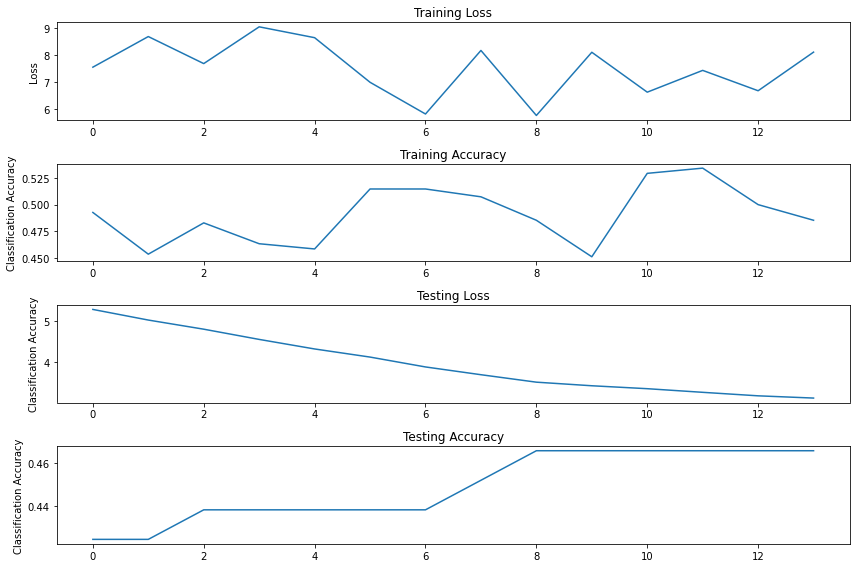

Min of Training Loss: 5.763210
Max of Training Accuracy: 0.533981
Mean of Training Loss: 7.527830
Mean of Training Accuracy: 0.490985
----
Max of Testing Accuracy: 0.465753


NameError: name 'val_loss_list' is not defined

In [633]:
__MLP.clf_report(train_loss, train_acc, val_loss_list, val_acc)